This code snippet executes and analyses the shrinkage of target word sets from all stimuli datasets

In [9]:
import json
import os
import random

random.seed(1111)

from transformers import BertTokenizer

In [10]:
# import original stimuli datasets

TEST_EXT = '.jsonl'
all_tests = sorted([entry[:-len(TEST_EXT)]
                        for entry in os.listdir()
                        if not entry.startswith('.') and entry.endswith('word' + TEST_EXT)])

tests_original = {bias_test: {'targ1': None, 'targ2': None, 'attr1': None, 'attr2': None} for bias_test in all_tests}
tests_shrunken = {bias_test: {'targ1': {}, 'targ2': {}, 'attr1': {}, 'attr2': {}} for bias_test in all_tests}

for test in all_tests:
    file = json.load(open(test+TEST_EXT, 'r'))
    tests_original[test]['targ1'] = file['targ1']['examples_singular']
    tests_original[test]['targ2'] = file['targ2']['examples_singular']
    tests_original[test]['attr1'] = file['attr1']['examples_singular']
    tests_original[test]['attr2'] = file['attr2']['examples_singular']

In [11]:
# load BERT (bbu) tokenizer from local files
tokenizer = BertTokenizer.from_pretrained('../models/bert/base-uncased/')

In [12]:
def filter_stimuli(stimuli_lst, tokenizer):
    """ Function to shrink word list """
    return [w.strip().lower() for w in stimuli_lst if w.strip().lower() in tokenizer.vocab]

for test in all_tests:
    # shrink original target word sets
    tests_shrunken[test]['targ1']['examples_singular'] = filter_stimuli(tests_original[test]['targ1'], tokenizer)
    tests_shrunken[test]['targ2']['examples_singular'] = filter_stimuli(tests_original[test]['targ2'], tokenizer)
    # save respective attribute word sets
    tests_shrunken[test]['attr1']['examples_singular'] = tests_original[test]['attr1']
    tests_shrunken[test]['attr2']['examples_singular'] = tests_original[test]['attr2']
    
    # target word sets have to be of equal size
    if len(tests_shrunken[test]['targ1']['examples_singular']) != len(tests_shrunken[test]['targ2']['examples_singular']):
        min_n = min([len(tests_shrunken[test]['targ1']['examples_singular']), len(tests_shrunken[test]['targ2']['examples_singular'])])
        # randomly sample min number of stimuli for both word sets
        if not len(tests_shrunken[test]['targ1']['examples_singular']) == min_n:
            tests_shrunken[test]['targ1']['examples_singular'] = random.sample(tests_shrunken[test]['targ1']['examples_singular'], min_n)
        else:
            tests_shrunken[test]['targ2']['examples_singular'] = random.sample(tests_shrunken[test]['targ2']['examples_singular'], min_n)


In [13]:
# save word sets
for test in all_tests:
    # only save test if target word sets are not empty
    if len(tests_shrunken[test]['targ1']['examples_singular']) > 0:
        with open('stimuli_logprob/shrunken_wd_sets/'+test+'.jsonl', 'w') as file:
            json.dump(tests_shrunken[test], file,  indent=4)

Despite datasets containing stimuli which consist of multiple words, e.g. `C3_term_word`, there are no target stimuli left after shrinking for the bias tests `IBD_name_word` and `EIBD_name_word`. Further, `C9m_name_word` does not differ with respect to the target words from `C9_name_word` and thus the following analysis is conducted for the remaining bias tests:
- C1_name
- C3_name
- C6_name
- C6_term
- C9_name
- C9_term
- Occ_name
- Occ_term

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

In [55]:
tests = ['C1_name_word', 'C3_name_word', 'C6_name_word', 'C9_name_word', 'Occ_name_word', 'C6_term_word', 'C9_term_word', 'Occ_term_word']
data = {'prop': [(len(tests_shrunken[test]['targ1']) / len(tests_original[test]['targ1']))*100 for test in tests]}
df = pd.DataFrame(data,columns=['prop'], index = tests)
print(df)

                     prop
C1_name_word    36.000000
C3_name_word    31.250000
C6_name_word   100.000000
C9_name_word    42.857143
Occ_name_word   57.692308
C6_term_word   100.000000
C9_term_word    66.666667
Occ_term_word  100.000000


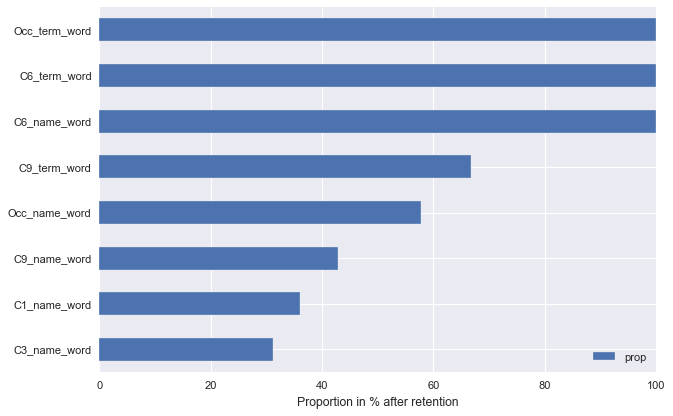

In [63]:
plt.style.use('seaborn')

df.sort_values(by='prop').plot.barh()
#plt.ylabel('Bias test')
plt.xlabel('Proportion in % after retention')
plt.savefig('../shrinkage.png',bbox_inches="tight")
plt.show()

For `C6_name_word`, `C6_term_word`, and `Occ_term_word`, all stimuli exist in vocab and thus no shrinkage.

In [59]:
print(df.mean())

prop    66.808265
dtype: float64


In [60]:
for test in ['C1_name_word', 'C3_name_word', 'C9_name_word', 'C9_term_word', 'Occ_name_word']:
    number_stimuli = len(tests_shrunken[test]['targ1'])
    if number_stimuli < 8:
        print(test)

C9_name_word
C9_term_word


Further, for `C9_name_word` and `C9_term_word` less than 8 stimuli per target word set remain after the shrinkage. This indicates no statistically significant concept representation.

To conclude, only 6 out of 12 bias test are satisfactory after the shrinkage.